<div><img style="float: right; width: 80px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Mi primer AE Convolucional con Keras<a id="top"></a>

<i><small>Authors: Félix José Fuentes Hurtado<br>Last update: 2023-09-29</small></i></div>

***

### Mi primer AutoEncoder Convolucional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder convolucional paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta.

Comenzemos recordando qué es un autoencoder convolucional. Para ello, mirad la imagen siguiente:

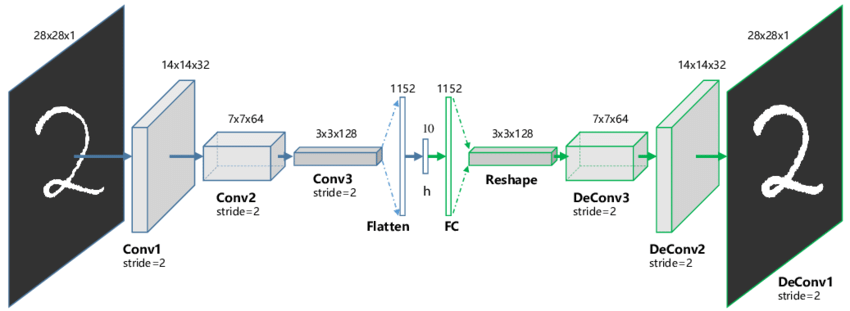

En ella podemos observar como consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

A lo largo de esta práctica implementaremos un autoencoder convolucional y visualizaremos el espacio latente ("bottleneck").

**¡Comenzemos!**

Vamos a implementar nuestro primer autoencoder convolucional. La arquitectura del autoencoder será la siguiente:

Para el encoder:

- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`

Para el decoder:

- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `valid`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 1 filtros de 3x3, activación `sigmoid` y padding `same`


**Pregunta**: ¿Qué tamaño tendrá el bottleneck?

**Respuesta**: Yendo de capa en capa desde la entrada: (28, 28, 1) --> (28, 28, 16) --> (14, 14, 16) --> (14, 14, 8) --> (7, 7, 4) --> (4, 4, 4)

En el último paso, al hacer el último pooling, pasaremos de 7x7 a 4x4, ya que irá obteniendo el máximo de cada región 2x2. Como la entrada tiene 7x7, en el último paso no tendrá 2x2 sino 2x1.

**Pregunta**: ¿Por qué escogemos `padding=valid` en la penúltima capa convolucional del decoder? Te ayudará calcular las dimensiones de entrada y salida de cada capa.

**Respuesta**: Si nos fijamos en los tamaños de cada entrada-salida del decoder, tenemos:

- (4, 4, 1) -> (4, 4, 4) (porque `padding='same'`, lo que consigue que entrada y salida tengan las mismas dimensiones de `HxW` y tenemos 4 kernels)
- (4, 4, 4) -> (8, 8, 4)
- (8, 8, 4) -> (8, 8, 8) (porque `padding='same'`)
- (8, 8, 8) -> (16, 16, 8)
- (16, 16, 8) -> (14, 14, 8) (porque `padding='VALID'`, lo que significa que los kernels de `3x3` "perderán" 1 píxel por "lado", haciendo un total de 2 píxels menos en altura y en anchura)
- (14, 14, 8) -> (28, 28, 8)
- (28, 28, 8) -> (28, 28, 1) (porque `padding='same'`)

Por lo tanto, la pérdida de 2 píxels por dimension está pensada adrede para conseguir un tamaño final de `(28, 28, 1)` que coincida con el de la entrada.

In [3]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 4) i.e. 64-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 4)           292 

Ahora obtendremos las imágenes y las normalizaremos entre 0 y 1: dividiremos entre 255, ya que las imágenes están codificadas con 8 bits sin signo (uint8).

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


Como vamos a trabajar con imágenes, tenemos que redimensionar los datos para que tengan 2 dimensiones: de 786 a (28, 28, 1), porque son imágenes en escala de grises.

In [3]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Tras esto, entrenamos nuestro DC (Deep Convolutional) AutoEncoder:

*(Atención: ahora es importante tener seleccionada GPU o TPU, de lo contrario el entrenaiento será muy lento)*

In [4]:
logs = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 17s 8ms/step - loss: 0.2421 - val_loss: 0.1619
Epoch 2/50
469/469 [==============================] - 7s 14ms/step - loss: 0.1521 - val_loss: 0.1433
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1398 - val_loss: 0.1352
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1334 - val_loss: 0.1296
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1289 - val_loss: 0.1259
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1257 - val_loss: 0.1231
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1235 - val_loss: 0.1213
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1218 - val_loss: 0.1198
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1206 - val_loss: 0.1188
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1193 - val_loss: 0.

También podemos visualizar las curvas de entrenamiento, que se guardan en la variable history:

In [5]:
logs.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
import matplotlib.pyplot as plt

In [6]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

NameError: ignored

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Además, podemos también mirar las representaciones obtenidas por el encoder, las cuales tienen unas dimensiones de 8x8x4.

Para poder visualizarlas en 2D, las redimensionaremos a 4x32.

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En teoría, en estas representaciones se encuentra la información necesaria para reconstruir los datos originales con el menor error posible.